In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [157]:
# From here - https://stackoverflow.com/questions/8044539/listing-available-devices-in-python-opencv
def returnCameraIndexes():
    # checks the first 10 indexes.
    index = 0
    arr = []
    i = 10
    while i > 0:
        cap = cv2.VideoCapture(index)
        if cap.read()[0]:
            arr.append(index)
            cap.release()
        index += 1
        i -= 1
    return arr

In [158]:
indexes = returnCameraIndexes(); print(indexes)

[0, 2]


In [4]:
# Use the VideoSource framework but pass 1 as src
from src.sources.video import VideoSource

In [5]:
video = VideoSource(src=1)
video.start()

In [6]:
_, frame = video.read(); print(frame.shape)

(480, 640, 2)


<IPython.core.display.Javascript object>


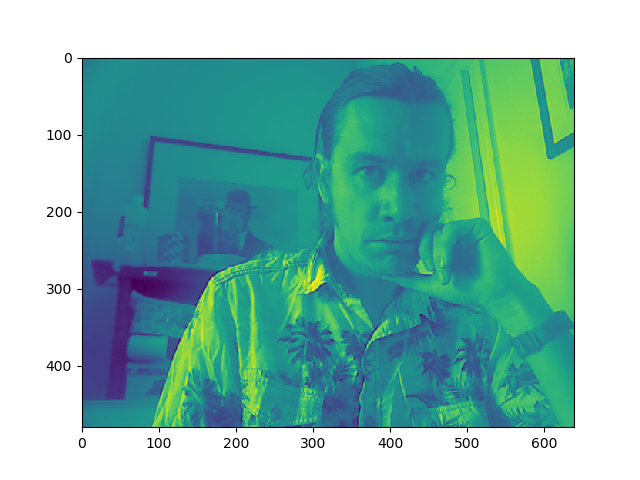

In [12]:
%matplotlib notebook
plt.imshow(frame[:, :, 0])

In [8]:
from src.sources.polar_mapping import split_field

For reference.

```
def split_field(input_image, LUT=None):
    """Convert image to polar and split across the visual field."""
    # If a look-up table is not passed, create one
    if LUT is None:
        max_size = max(input_image.shape)
        LUT = calculateLUT(max_size)
    out_image = convert_image(input_image, LUT)
    # I could possibly change the mapping above to avoid flipping
    # Flipping arranges similar to cortex
    right_image = np.flip(out_image[:180, :])
    left_image = np.flipud(out_image[180:, :])
    return norm_scale(left_image), norm_scale(right_image)
```

In [9]:
left, right = split_field(frame[:, :, 0])

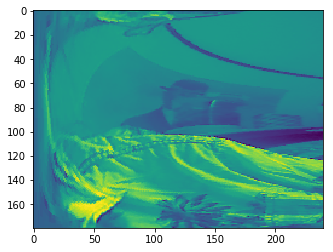

In [10]:
plt.imshow(left)

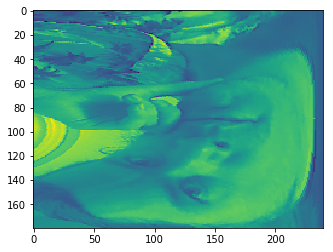

In [11]:
plt.imshow(right)

## Gaze Dynamics

Now we look at introducing some gaze dynamics. The gaze positions features of interest in the centre of the visual field, and thus provides for symmetry.

How gaze may work:
* Define a co-ordinate of gaze - a centre of vision. This is an array of length 2 - first entry is row index, second entry is column index. This can be an integer.
* If we define a default centre of the image as 0, 0, then use positive and negative values to index in x, y directions.
* Extract a region around the gaze co-ord.
* Perform retinotopic mapping.

The gaze can change. If we assume ternary values, the gaze may change by +/- 1 pixels per timestep.
* Do we start by modelling gaze as a random walk?

In the above image my face is around (200, 415).

We restrict gaze to the inner area of viewable space - so if the area is 100 (+/-50), we restrict to image size +/-50

In [24]:
# Define a 2D coordinate for the gaze centre - (y, x) - matching (row, col) array convention
gaze_centre = np.zeros(shape=(2, 1), dtype=np.int16)
# Define a fovea size
fovea_size = (50, 100)

In [25]:
y, x = gaze_centre; print(y, x)

[0] [0]


In [28]:
def get_gaze_area(image, gaze_centre, fovea_size):
    # Check gaze within inner image
    rows, cols = image.shape
    y, x = gaze_centre
    height, width = fovea_size
    assert y < (rows-height) and x < (cols-width)
    # Extract region and return
    return image[y-height:y+height, x-width:x+width]

In [29]:
region = get_gaze_area(frame[:, :, 0], np.asarray([200, 415]), fovea_size)

<IPython.core.display.Javascript object>


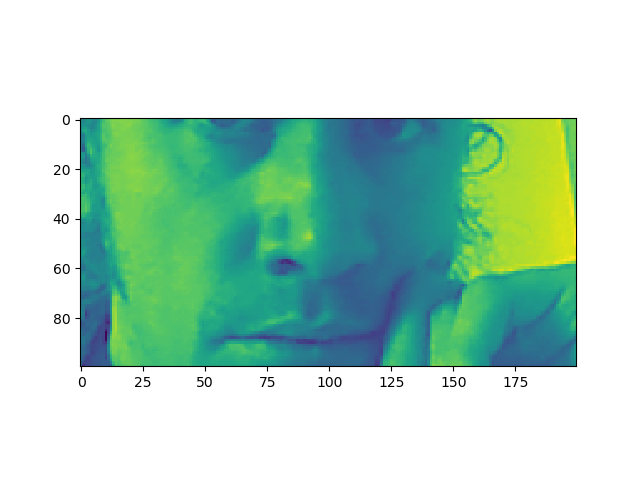

In [30]:
plt.imshow(region)

<IPython.core.display.Javascript object>


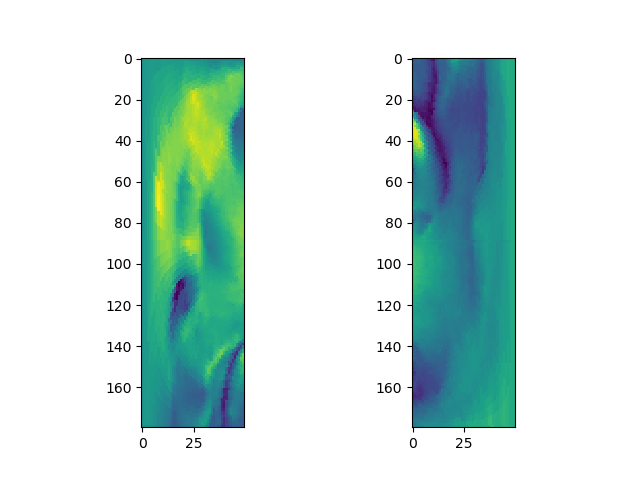

In [31]:
region_left, region_right = split_field(region)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(region_left); axes[1].imshow(region_right)

In [35]:
from src.sources.polar_mapping import convert_image, calculateLUT, calculatebackLUT, show_field

In [36]:
max_size = max(region.shape); print(max_size)

200


<IPython.core.display.Javascript object>


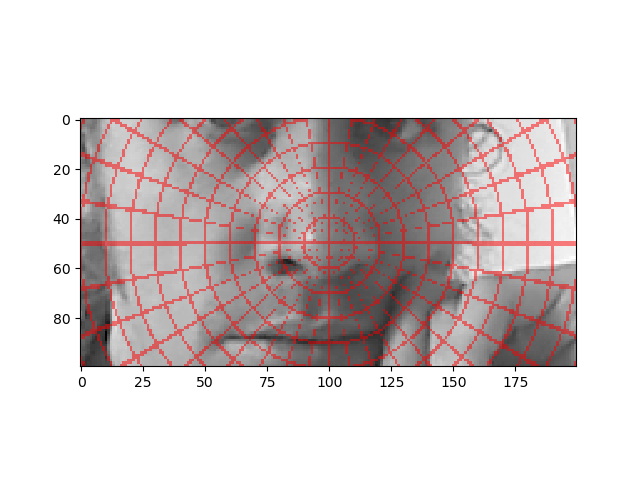

In [41]:
LUT = calculateLUT(max_size)
backLUT = calculatebackLUT(max_size)
show_field(region, backLUT, ticks=10)

Each square has a similar size representation on the retina.

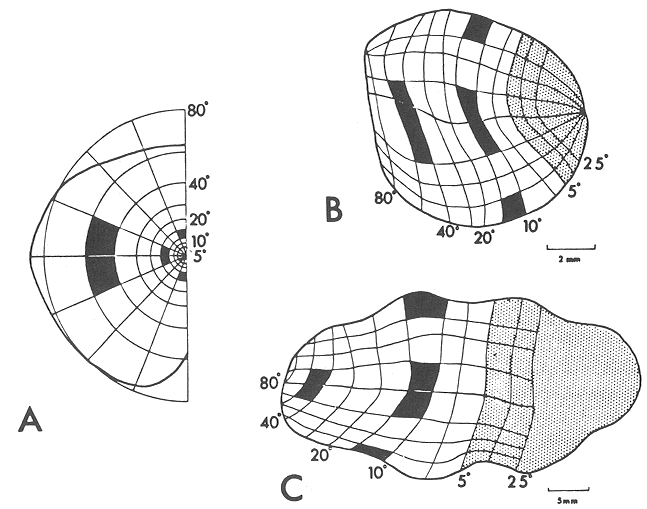

In [47]:
print(f"LUT dimensions: {LUT.shape}\nBackLUT dimensions: {backLUT.shape}")

LUT dimensions: (200, 360, 2)
BackLUT dimensions: (400, 400, 2)


So this will cover the whole image space...

<IPython.core.display.Javascript object>


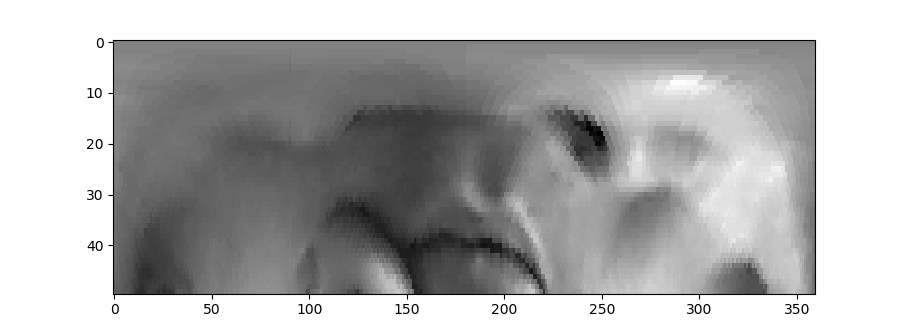

In [44]:
converted = convert_image(region, LUT)
plt.imshow(converted.T, cmap='gray', aspect="auto")

The eyes are chopped off in the above left/right images.

How is the image on the visual cortex arranged? 
* The fovea area appears square but the above is long - ah as we are splitting the field, we actually can have a 2:1 ratio.

In [49]:
img = region
# Use centre of image as origin
centre_row = img.shape[0] // 2
centre_col = img.shape[1] // 2
print(centre_row, centre_col)

50 100


In [53]:
radius = int(max(img.shape)/2); print(radius)

100


In [61]:
# Theta on Y-axis is closer to cortex maps
output_image = np.zeros(shape=(360, radius))
rows, cols = img.shape
# Iterate around angles of field of view
for angle in range(0, 360):
    # Iterate over radius
    for r in range(0, radius):
        # Get mapped x, y
        (row, col) = tuple(LUT[r, angle])
        # Translate origin to centre
        # This makes rotation clockwise from positive y axis
        m_row = centre_row - row
        m_col = col + centre_col
        if m_row < rows and m_col < cols:
            output_image[angle, r] = img[m_row, m_col]

<IPython.core.display.Javascript object>


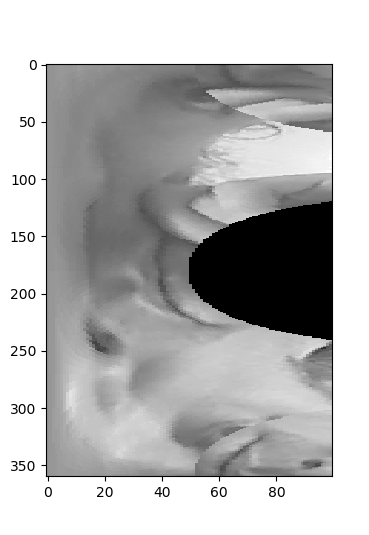

In [64]:
plt.imshow(output_image, cmap='gray', aspect="auto")

So we need to exclude those hemisphere areas if we want the extra information.

Let's just take one hemisphere to try to map better onto the image of the cortex above.

In [75]:
# Theta on Y-axis is closer to cortex maps
output_image = np.zeros(shape=(180, radius))
rows, cols = img.shape
# Iterate around angles of field of view
for angle in range(0, 180):
    # Iterate over radius
    for r in range(0, radius):
        # Get mapped x, y
        (row, col) = tuple(LUT[r, angle])
        # Translate origin to centre
        # This makes rotation clockwise from positive y axis
        m_row = centre_row - row
        m_col = col + centre_col
        if m_row < rows and m_col < cols:
            output_image[angle, r] = img[m_row, m_col]

<IPython.core.display.Javascript object>


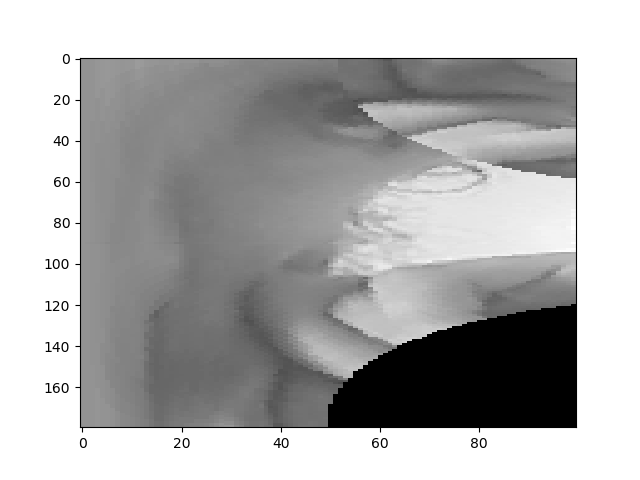

In [78]:
# Also flip to match orientation above.
plt.imshow(output_image, cmap='gray', aspect="auto")

This image isn't too different from the cortex mapping above - towards the left-hand side of the image we have some tapering. 

You could take two image halves: in the above 50-100 is of height 180, 0-50 is of height 118-58 = 60.

You want to stretch that second half to make square?

What's the formula for the upper area we need to remove. Could we mask based on the zero values of the other half?

Or we look at where r>r_min.

***Or we put the image in a bigger zero image...***

In [82]:
print(region.shape, max(region.shape), min(region.shape))

(100, 200) 200 100


In [86]:
# Calculate padding on smaller dimension
padding = (max(region.shape)-min(region.shape))//2; print(padding)

50


In [96]:
# https://stackoverflow.com/questions/10871220/making-a-matrix-square-and-padding-it-with-desired-value-in-numpy
def squarify(M, val):
    (a, b)=M.shape
    pad_factor = abs(a-b)//2
    if a < b:
        padding=((pad_factor, pad_factor), (0, 0))
    else:
        padding=((0, 0), (pad_factor, pad_factor))
    return np.pad(M, padding, mode='constant', constant_values=val)

In [97]:
padded = squarify(region, 0)

<IPython.core.display.Javascript object>


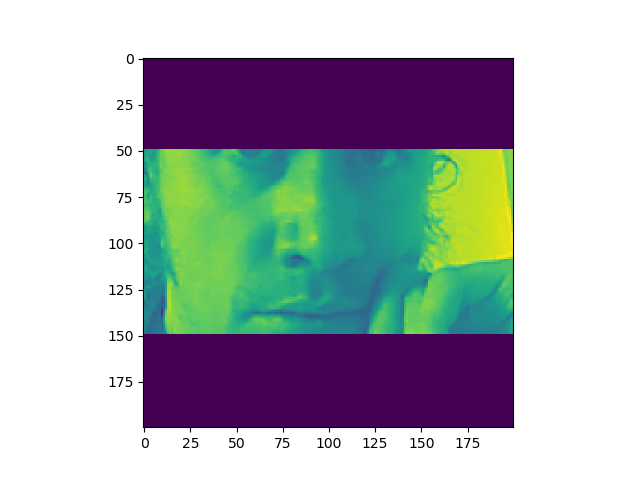

In [98]:
plt.imshow(padded)

<IPython.core.display.Javascript object>


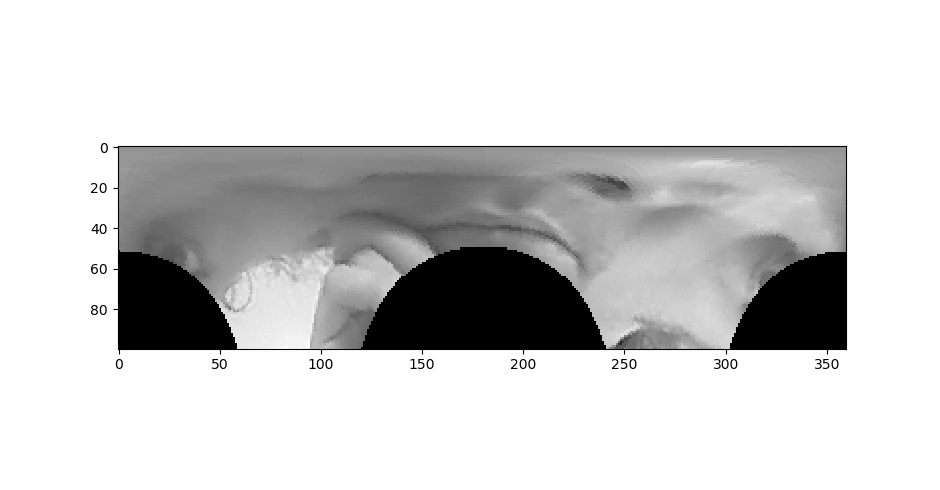

In [125]:
output = convert_image(padded, LUT)

plt.imshow(output.T, cmap="gray")

In [123]:
output.max(), output.min()

(221.0, 0.0)

<IPython.core.display.Javascript object>


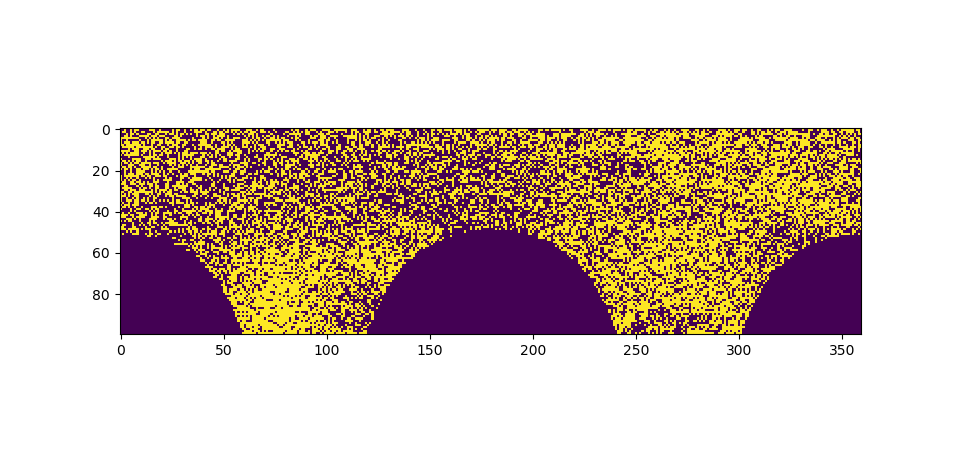

In [126]:
random_ints = np.random.randint(255, size=output.shape)
pbt = np.where(output > random_ints, 1, 0)
plt.imshow(pbt.T)

<IPython.core.display.Javascript object>


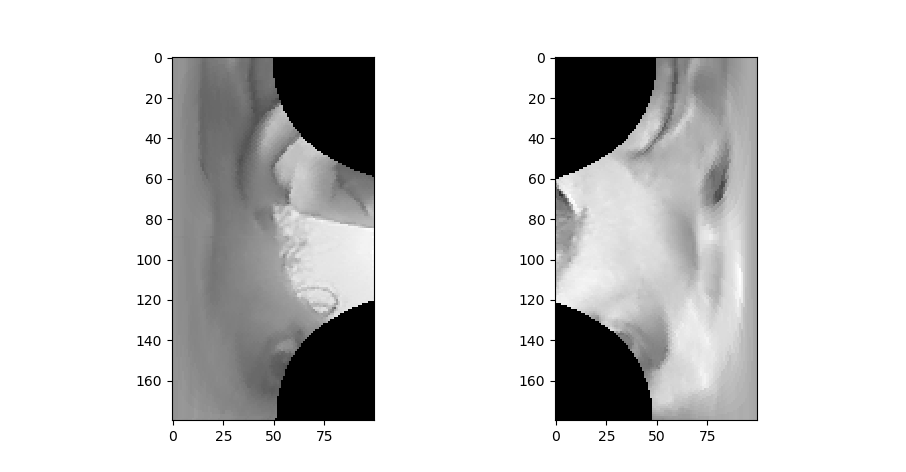

In [127]:
right_image = np.flipud(output[:180, :])
left_image = np.fliplr(output[180:, :])
fig, axes = plt.subplots(1, 2)
axes[0].imshow(right_image, cmap="gray"); axes[1].imshow(left_image, cmap="gray")

The flipping above is consistent with the projection onto each hemisphere.

But the retinotopic maps from the text books above are longer than tall...

Y axis will also be 180 as 180 degrees. X axis is set by region size. Maybe we can stride in the degree direction? 

In [132]:
def convert_image(img, LUT, angle_step=1):
    """
    Convert image from cartesian to polar co-ordinates.

    img is a numpy 2D array having shape (height, width)
    LUT is a numpy array having shape (diameter, 180, 2)
    storing [x, y] co-ords corresponding to [r, angle]
    """
    # Use centre of image as origin
    centre_row = img.shape[0] // 2
    centre_col = img.shape[1] // 2
    # Determine the largest radius
    if centre_row > centre_col:
        radius = centre_col
    else:
        radius = centre_row
    # Theta on Y-axis is closer to cortex maps
    output_image = np.zeros(shape=(360, radius))
    # Iterate around angles of field of view
    for angle in range(0, 360, angle_step):
        # Iterate over radius
        for r in range(0, radius):
            # Get mapped x, y
            (row, col) = tuple(LUT[r, angle])
            # Translate origin to centre
            # This makes rotation clockwise from positive y axis
            m_row = centre_row - row
            m_col = col+centre_col
            output_image[angle, r] = img[m_row, m_col]
    # Skip missed values
    output_image = output_image[::angle_step, :]
    return output_image

<IPython.core.display.Javascript object>


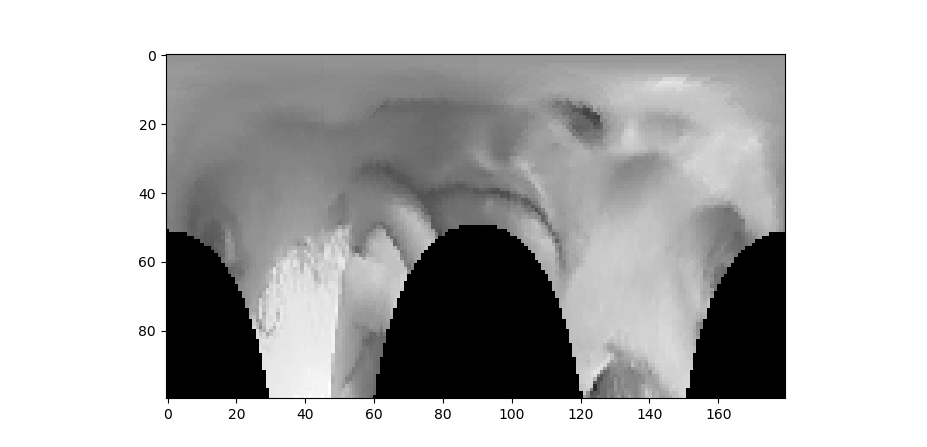

In [133]:
output = convert_image(padded, LUT, angle_step=2)

plt.imshow(output.T, cmap="gray")

<IPython.core.display.Javascript object>


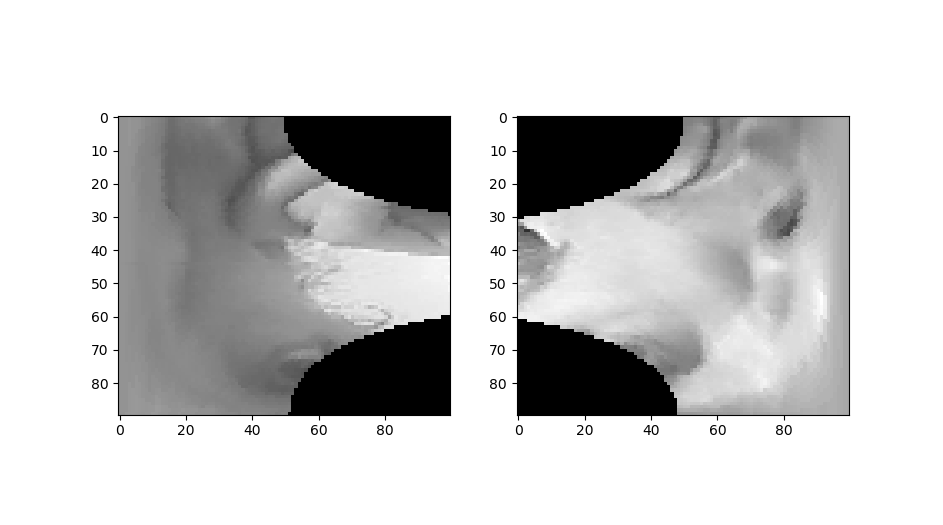

In [135]:
right_image = np.flipud(output[:90, :])
left_image = np.fliplr(output[90:, :])
fig, axes = plt.subplots(1, 2)
axes[0].imshow(right_image, cmap="gray"); axes[1].imshow(left_image, cmap="gray")

The original image was a region of 200 by 100, i.e. 20000 pixels. The images above are 100 by 90 - 9000 pixels (with some zero space).

But check the Y axis in the figures above - in the cortex map it runs from 0 degrees to 80 degrees - this is the radius - so we want a finer resolution in the radius direction to increase the resolution in the radius direction.

So to 40 degrees in the field of vision is approximately half the radius - so the resolution is double in the radius direction.

So if our original radius is 50 then we should have around a resolution of 25 in the angle direction - say a stride of 8.

<IPython.core.display.Javascript object>


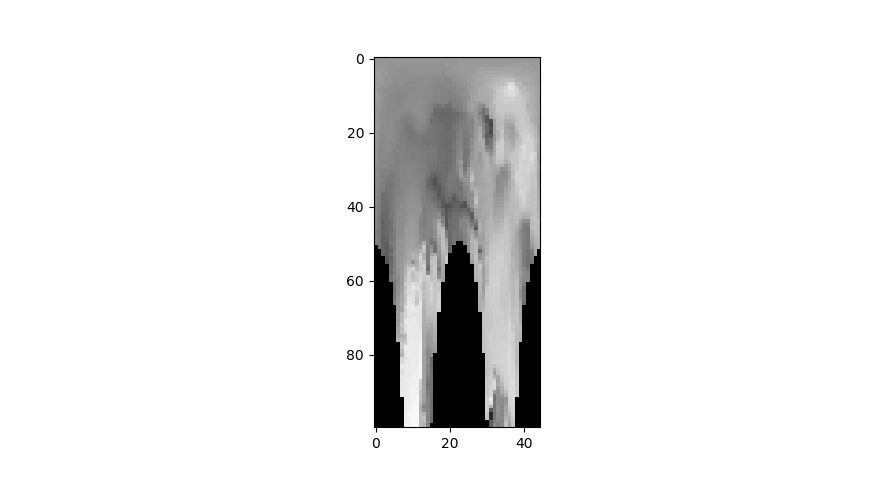

In [136]:
output = convert_image(padded, LUT, angle_step=8)

plt.imshow(output.T, cmap="gray")

In [140]:
output.shape

(45, 100)

<IPython.core.display.Javascript object>


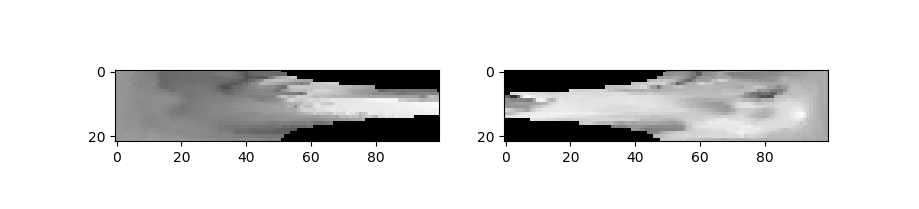

In [141]:
right_image = np.flipud(output[:output.shape[0]//2, :])
left_image = np.fliplr(output[(output.shape[0]+1)//2:, :])
fig, axes = plt.subplots(1, 2)
axes[0].imshow(right_image, cmap="gray"); axes[1].imshow(left_image, cmap="gray")

In [142]:
print(right_image.shape, left_image.shape)

(22, 100) (22, 100)


<IPython.core.display.Javascript object>


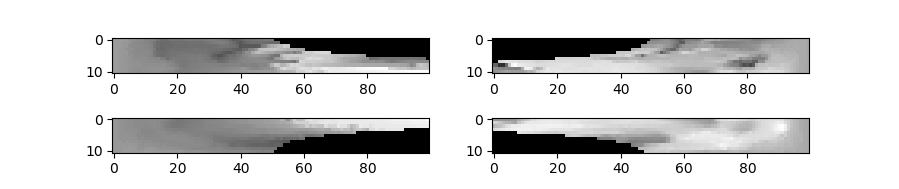

In [145]:
# Now plot top and bottom visual fields separately
fig, axes = plt.subplots(2, 2)
# Top 
axes[0, 0].imshow(right_image[:11, :], cmap="gray")
# Bottom
axes[1, 0].imshow(right_image[11:, :], cmap="gray")
# Top
axes[0, 1].imshow(left_image[:11, :], cmap="gray")
# Bottom
axes[1, 1].imshow(left_image[11:, :], cmap="gray")

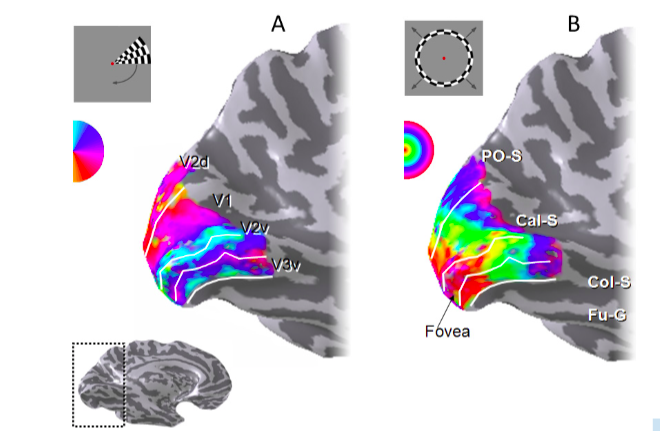

So with respect to the above, the leftmost and rightmost of each column of images is at the fovea and we have the x axis spanning out from the fovea and we have thin strips of angle with mirroring in the upper and lower fields.

## Visualiser

It would be good to have a visualiser where:
* we extract a region from the centre.
* we show the original image, the region and the four subplot above (3 x 2).

In [154]:
from matplotlib.animation import FuncAnimation

class VideoViewer:
    """Object to view video via matplotlib."""
    def __init__(self, video_source, angle_step=1):
        """Initialise."""
        self.video = video_source
        self.angle_step = angle_step
        if not self.video.started:
            self.video.start()
        # Set up plots
        self.figure, self.axes = plt.subplots(2, 3)
        self.animation = FuncAnimation(
            self.figure, self.update, interval=200, blit=True
        )
        # Initialise LUT for polar
        self.region_size = (50, 100)
        self.LUT = calculateLUT(max_size)
        # Return a list of images for display
        images = self.process_frame()
        # Initialise subplots
        self.displayed = [
            self.axes.ravel()[i].imshow(
                images[i], cmap="gray", animated=True, aspect="auto"
            )
            for i in range(len(images))
        ]
        # Clear ticks
        for ax in self.axes.ravel():
            ax.xaxis.set_major_locator(plt.NullLocator())
            # ax.yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(wspace=0.5)       

    def process_frame(self):
        """Process a frame."""
        images = list()
        # Get frame
        ret, frame = self.video.read()
        # Get Y component
        Y = frame[:, :, 0]
        if ret:
            # Add large frame as first image
            images.append(Y)
            rows, cols = Y.shape
            # Set region as centre (we'll move the camera first)
            gaze_centre = (rows//2, cols//2)
            # Get central region
            region = get_gaze_area(Y, gaze_centre, self.region_size)
            # Pad and convert
            padded = squarify(region, 0)
            max_size = max(self.region_size)
            output = convert_image(padded, self.LUT, angle_step=self.angle_step)
            right_image = np.flipud(output[:output.shape[0]//2, :])
            left_image = np.fliplr(output[(output.shape[0]+1)//2:, :])
            # Add top of left image
            images.append(right_image[:right_image.shape[0]//2, :])
            # Add bottom of left image
            images.append(left_image[:left_image.shape[0]//2, :])
            # Add region as an image
            images.append(region)
            # Add top of left image
            images.append(right_image[right_image.shape[0]//2:, :])
            # Add bottom of left image
            images.append(left_image[left_image.shape[0]//2:, :])
        return images

    def update(self, i):
        """Code for frame update."""
        images = self.process_frame()
        for i, box in enumerate(self.displayed):
            box.set_data(images[i])
        return self.figure

    def show(self):
        plt.show()

    def __exit__(self, exec_type, exc_value, traceback):
        """Extra code to close camera."""
        self.video.stop()

<IPython.core.display.Javascript object>


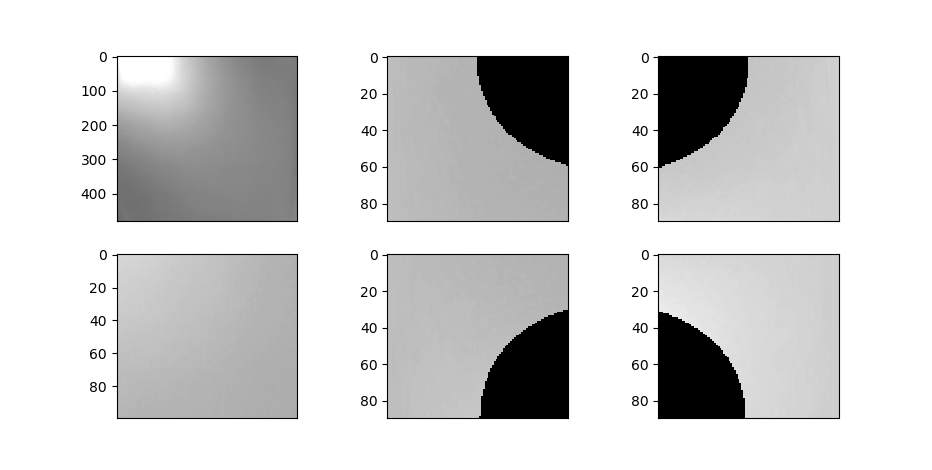

In [156]:
viewer = VideoViewer(video)

If there are about 1 million sensory signals coming into the cortex and at least 50% are taken up by the fovea, this suggests a fovean resolution of about 700 by 700.

Also when looking at text a 2MP camera isn't detailed enough to read the text.

In [162]:
cap = cv2.VideoCapture(2)
cap.set(cv2.CAP_PROP_CONVERT_RGB, 0)
# Watch out - UV are interlaced
# Set width / height if passed (locks to nearest availabe resolution)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 2000)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 2000)
# Grab a frame
grabbed, frame = cap.read()
print(frame.shape)

(800, 1280, 2)


In [163]:
cap.release()

<IPython.core.display.Javascript object>


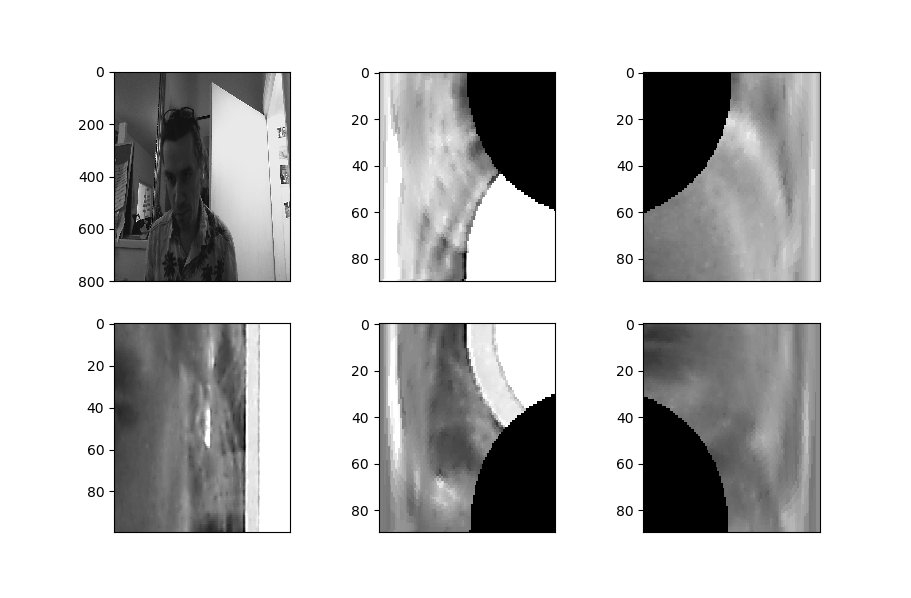

In [166]:
video2 = VideoSource(2, 2000, 2000)
video2.start()
viewer2 = VideoViewer(video2)

In [167]:
video2.stop()

Trying to read is informative!

The brain centres by trying to match up the images in each of the four quadrants. This also seems to work for speech (looking at lips) and eyes.

The better resolution camera seems to work better. We are nearly there at 1280 * 800 - suggests actual resolution is UHDish for fovea.

You could get the same effect with two camera - a lens to focus a small area onto all of the array and a large fish eye.

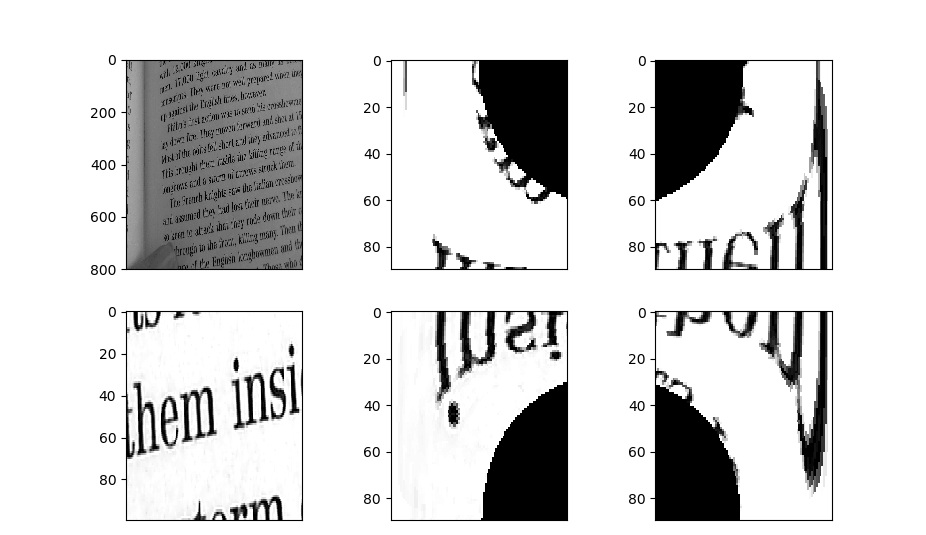

The writing is backwards in the brain - it goes from right > left. The word spacing at that distance is such that you only have single words present. You focus by making the letter height roughly equal on the upper and lower portion. The differences between the upper and lower field determine the letter. 

This also suggests that letter height can vary for the same pattern. Suggesting that vertical information is combined.

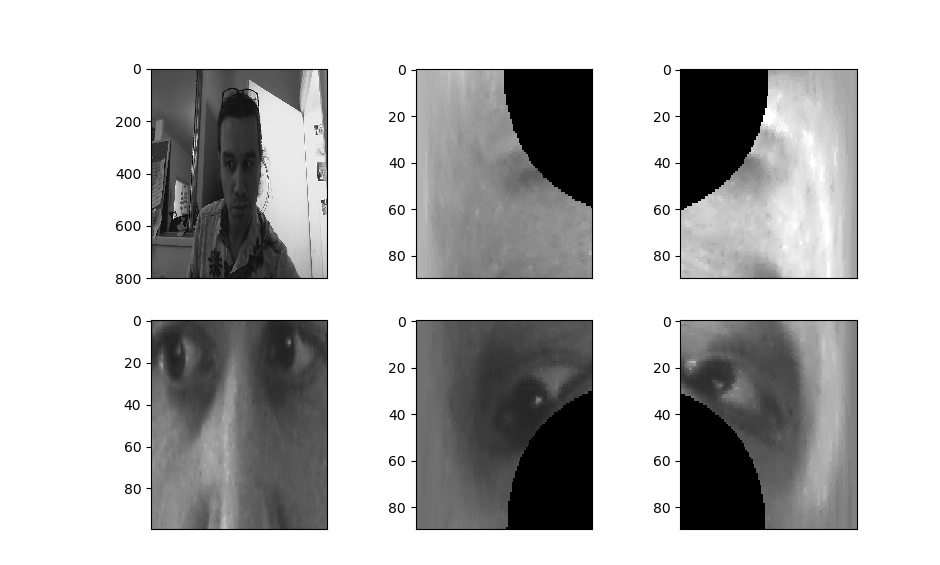

In [ ]:
random_ints = np.random.randint(255, size=output.shape)
pbt = np.where(output > random_ints, 1, 0)